In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as st 
import os
os.chdir('C:\\Users\\Shashi Katteri\\Downloads')

In [11]:
df1=pd.read_csv('train.csv')
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
df2=pd.read_csv('test.csv')
df2.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
df=pd.concat([df1,df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [14]:
df['Cabin_yes']=(~df['Cabin'].isnull()).astype(int)

In [149]:
df.Cabin_yes.value_counts()

0    1014
1     295
Name: Cabin_yes, dtype: int64

In [16]:
df.Embarked=df.Embarked.fillna(method='bfill')
df.Fare=df.Fare.fillna(method='ffill')

In [27]:
df['Age']=df['Age'].replace(np.nan,28)

In [30]:
df=df.drop('Cabin',axis=1)

In [48]:
df.isnull().sum()

Age             0
Fare            0
Parch           0
Pclass          0
SibSp           0
Survived      418
Cabin_yes       0
Embarked_Q      0
Embarked_S      0
Sex_male        0
dtype: int64

In [46]:
df=df.drop(['PassengerId','Name','Ticket'],axis=1)
df=pd.get_dummies(df,columns=['Embarked','Sex'],drop_first=True)

In [47]:
test=df[df.Survived.isnull()==True]
train=df[df.Survived.isnull()==False]

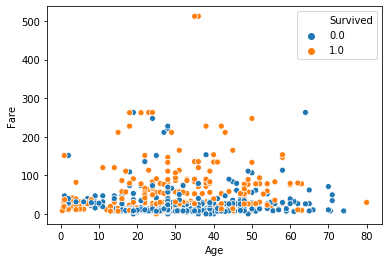

In [49]:
sns.scatterplot(data=df,x='Age',y='Fare',hue='Survived')

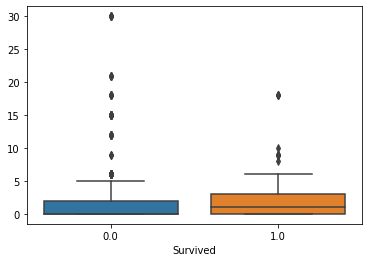

In [77]:
sns.boxplot(x=df['Survived'],y=(df['SibSp']+df['Parch'])*df['Pclass'])

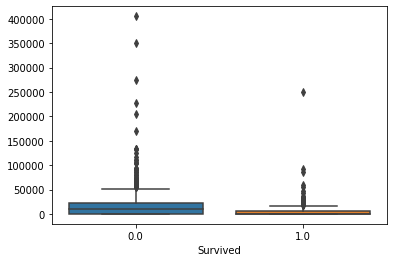

In [120]:
sns.boxplot(x=df['Survived'],y=df['Age']**df['Pclass'])

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold,cross_val_score
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score,classification_report,confusion_matrix

In [112]:
x=train.drop('Survived',axis=1)
y=train['Survived']

In [65]:
def mod_score(algo,x,y,params=None):
    mod=algo.fit(x,y)
    cv1=cross_val_score(algo,x,y,cv=5,scoring='accuracy')
    cv2=cross_val_score(algo,x,y,cv=5,scoring='roc_auc')
    print('\nAccuracy : ',cv1.mean())
    print('ROC AUC score : ',cv2.mean())
    return mod
    

In [89]:
def rand_search(algo,params,x,y):
    rs=RandomizedSearchCV(algo,param_distributions=params,random_state=0,n_jobs=-1,n_iter=100,scoring='roc_auc',cv=10)
    mod=rs.fit(x,y)
    print(mod.best_score_)
    return mod.best_params_

In [44]:
rfc_params={'n_estimators':st.randint(50,300),
    'criterion':['gini','entropy'],
    'max_depth':st.randint(2,20),
    'min_samples_split':st.randint(2,100),
    'min_samples_leaf':st.randint(2,100)}
lgb_params={ 'num_leaves':st.randint(31,60),
   'max_depth':st.randint(2,20),
    'learning_rate':st.uniform(0,1),
    'n_estimators':st.randint(50,300),
    'min_split_gain':st.uniform(0,0.3)}

In [66]:
def get_models(x,y):
    rbp=rand_search(RandomForestClassifier(),rfc_params,x,y)
    lbp=rand_search(LGBMClassifier(),lgb_params,x,y)
    lr=LogisticRegression(solver='liblinear')
    rfc=RandomForestClassifier(**rbp)
    lgb=LGBMClassifier(**lbp)
    models={'Logistic Regression':lr,'Random Forest':rfc,'Light GBM':lgb}
    m={}
    for i in models:
        print('\n',i)
        m[i]=mod_score(models[i],x,y)
    return m

In [69]:
x1=x
ss=StandardScaler()
d=ss.fit_transform(x)
x1['sum']=d.sum(axis=1)
x1['min']=d.min(axis=1)
x1['max']=d.max(axis=1)
x1['skew']=st.skew(d,axis=1)
x1['kurt']=st.kurtosis(d,axis=1)
x1['std']=d.std(axis=1)

In [70]:
m1=get_models(x1,y)

0.8685585264408793
0.8755358911241264

 Logistic Regression

Accuracy :  0.791256041679744
ROC AUC score :  0.8589428121758186

 Random Forest

Accuracy :  0.8002636369342792
ROC AUC score :  0.864177472417694

 Light GBM

Accuracy :  0.8058565061829137
ROC AUC score :  0.8703600524591749


In [129]:
x2=x.copy()
x2['fam_size']=(x['SibSp']+x['Parch'])
x2['fare/class']=x['Fare']/x['Pclass']
x2['Age_class']=x['Age']*x['Pclass']
x2=x2.drop(['SibSp','Parch'],axis=1)

In [115]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
Age           891 non-null float64
Fare          891 non-null float64
Parch         891 non-null int64
Pclass        891 non-null int64
SibSp         891 non-null int64
Cabin_yes     891 non-null int32
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
Sex_male      891 non-null uint8
dtypes: float64(2), int32(1), int64(3), uint8(3)
memory usage: 47.9 KB


In [130]:
m2=get_models(x2,y)

0.8726588291882409
0.8771798092974563

 Logistic Regression

Accuracy :  0.7934906785512523
ROC AUC score :  0.8516149309562457

 Random Forest

Accuracy :  0.8271985437197916
ROC AUC score :  0.8699344384742329

 Light GBM

Accuracy :  0.8204318624066286
ROC AUC score :  0.8730276331441305


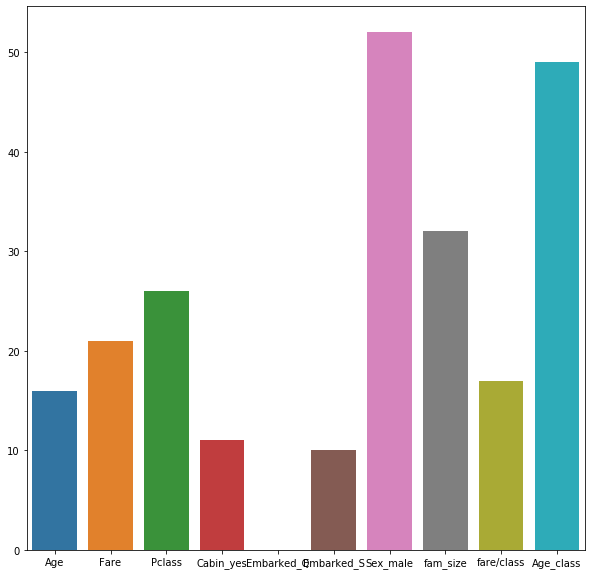

In [131]:
plt.figure(figsize=(10,10))
sns.barplot(x=x2.columns,y=m2['Light GBM'].feature_importances_)

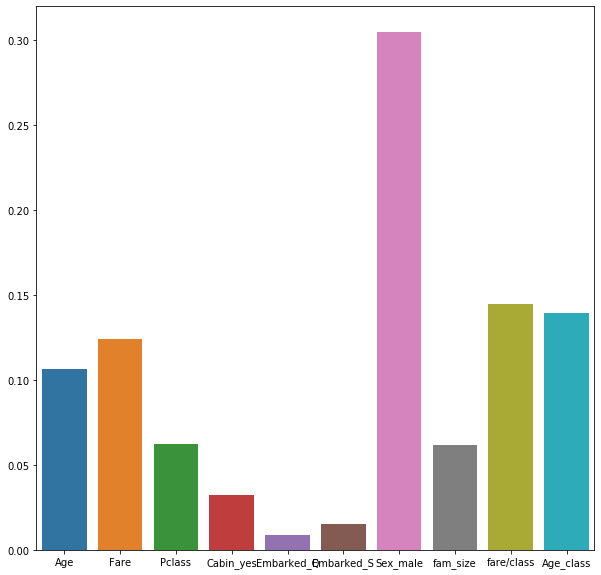

In [132]:
plt.figure(figsize=(10,10))
sns.barplot(x=x2.columns,y=m2['Random Forest'].feature_importances_)

In [134]:
test=test.drop('Survived',axis=1)

In [135]:
t=test.copy()
t['fam_size']=(test['SibSp']+test['Parch'])
t['fare/class']=test['Fare']/test['Pclass']
t['Age_class']=test['Age']*test['Pclass']
t=t.drop(['SibSp','Parch'],axis=1)

In [140]:
from sklearn.ensemble import VotingClassifier
vc=VotingClassifier(models,voting='soft',weights=[1,1])

In [138]:
rbp=rand_search(RandomForestClassifier(),rfc_params,x2,y)
lbp=rand_search(LGBMClassifier(),lgb_params,x2,y)
lr=LogisticRegression(solver='liblinear')
rfc=RandomForestClassifier(**rbp)
lgb=LGBMClassifier(**lbp)
models=[('Random Forest',rfc),('Light GBM',lgb)]

0.8707952352658234
0.8771798092974563


In [141]:
final_mod=vc.fit(x2,y)

In [142]:
Survived_test=final_mod.predict(t)

In [143]:
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':Survived_test})
results.to_csv('results.csv')

In [146]:
result_lgb=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':m2['Light GBM'].predict(t)})
result_lgb.to_csv('results_lgb.csv')

In [148]:
d=pd.concat([df1,df2],sort=False)

In [150]:
d['Cabin_yes']=(~d['Cabin'].isnull()).astype(int)

In [151]:
d.Cabin_yes.value_counts()

0    1014
1     295
Name: Cabin_yes, dtype: int64

In [152]:
d.Embarked=d.Embarked.fillna(method='bfill')
d.Fare=d.Fare.fillna(method='ffill')

In [153]:
d['Age']=d['Age'].replace(np.nan,28)

In [154]:
d=d.drop('Cabin',axis=1)

In [155]:
d=pd.get_dummies(d,columns=['Embarked','Sex'],drop_first=True)

In [157]:
d['title']=d['Name'].str.split(',')

In [169]:
def split(x):
    y=x.split(',')
    y1=y[1].split('.')
    return y1[0]

In [209]:
d['Title']=d.Name.apply(split)
#d=d.drop('title',axis=1)

In [212]:
d['Title'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Others     34
Name: Title, dtype: int64

In [211]:
def filt(x):
    if x in [' Mr',' Miss',' Mrs',' Master']:
        return x[1:]
    else :
        return 'Others'
d['Title']=d['Title'].apply(filt)

In [213]:
d=pd.get_dummies(d,columns=['Title'])
d=d.drop('Title_Others',axis=1)

In [214]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 17 columns):
PassengerId     1309 non-null int64
Survived        891 non-null float64
Pclass          1309 non-null int64
Name            1309 non-null object
Age             1309 non-null float64
SibSp           1309 non-null int64
Parch           1309 non-null int64
Ticket          1309 non-null object
Fare            1309 non-null float64
Cabin_yes       1309 non-null int32
Embarked_Q      1309 non-null uint8
Embarked_S      1309 non-null uint8
Sex_male        1309 non-null uint8
Title_Master    1309 non-null uint8
Title_Miss      1309 non-null uint8
Title_Mr        1309 non-null uint8
Title_Mrs       1309 non-null uint8
dtypes: float64(3), int32(1), int64(4), object(2), uint8(7)
memory usage: 156.3+ KB


In [217]:
test1=d[d.Survived.isnull()==True]
train1=d[d.Survived.isnull()==False]

In [218]:
x=train1.drop(['Survived','Ticket','Name','PassengerId'],axis=1)
y=train1['Survived']

In [220]:
x3=x.copy()
x3['fam_size']=(train1['SibSp']+train1['Parch'])
x3['fare/class']=train1['Fare']/train1['Pclass']
x3['Age_class']=train1['Age']*train1['Pclass']
x3=x3.drop(['SibSp','Parch'],axis=1)

In [221]:
x3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 14 columns):
Pclass          891 non-null int64
Age             891 non-null float64
Fare            891 non-null float64
Cabin_yes       891 non-null int32
Embarked_Q      891 non-null uint8
Embarked_S      891 non-null uint8
Sex_male        891 non-null uint8
Title_Master    891 non-null uint8
Title_Miss      891 non-null uint8
Title_Mr        891 non-null uint8
Title_Mrs       891 non-null uint8
fam_size        891 non-null int64
fare/class      891 non-null float64
Age_class       891 non-null float64
dtypes: float64(4), int32(1), int64(2), uint8(7)
memory usage: 58.3 KB


In [222]:
m3=get_models(x3,y)

0.8706555753614577
0.87416849163908

 Logistic Regression

Accuracy :  0.8294017952419811
ROC AUC score :  0.8716841666862198

 Random Forest

Accuracy :  0.8350134957002071
ROC AUC score :  0.874668395515729

 Light GBM

Accuracy :  0.824913690289373
ROC AUC score :  0.8768467755525171


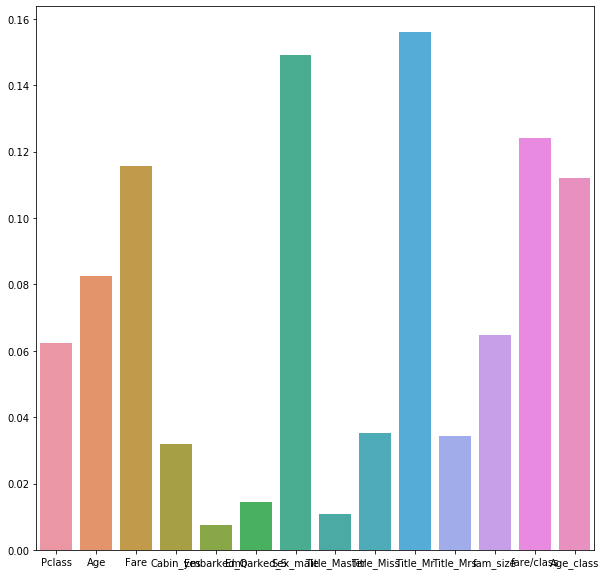

In [223]:
plt.figure(figsize=(10,10))
sns.barplot(x=x3.columns,y=m3['Random Forest'].feature_importances_)

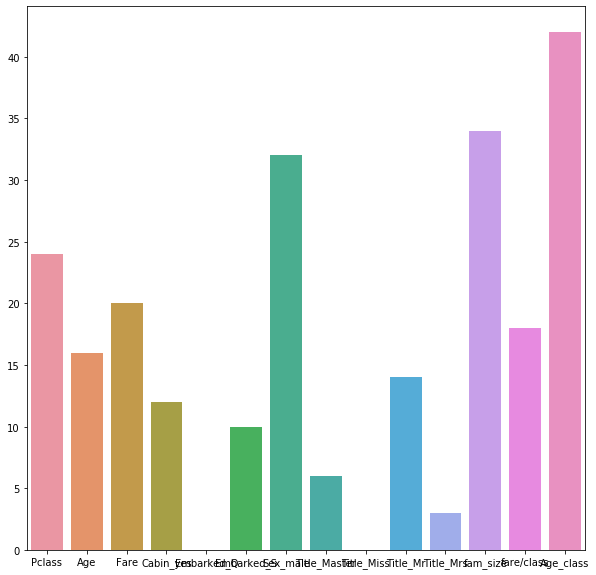

In [224]:
plt.figure(figsize=(10,10))
sns.barplot(x=x3.columns,y=m3['Light GBM'].feature_importances_)

In [225]:
test1=test1.drop('Survived',axis=1)

In [231]:
t=test1.copy()
t['fam_size']=(test1['SibSp']+test1['Parch'])
t['fare/class']=test1['Fare']/test1['Pclass']
t['Age_class']=test1['Age']*test1['Pclass']
t=t.drop(['SibSp','Parch'],axis=1)

In [239]:
t=t.drop(['PassengerId','Name','Ticket'],axis=1)

In [233]:
rbp=rand_search(RandomForestClassifier(),rfc_params,x3,y)
lbp=rand_search(LGBMClassifier(),lgb_params,x3,y)
lr=LogisticRegression(solver='liblinear')
rfc=RandomForestClassifier(**rbp)
lgb=LGBMClassifier(**lbp)
models1=[('Random Forest',rfc),('Light GBM',lgb),('Logistic Regression',lr)]
models2=[('Random Forest',rfc),('Light GBM',lgb)]
models3=[('Random Forest',rfc),('Logistic Regression',lr)]
models4=[('Light GBM',lgb),('Logistic Regression',lr)]


0.8717609144667969
0.87416849163908


In [236]:
from sklearn.ensemble import VotingClassifier
vc1=VotingClassifier(models1,voting='soft',weights=[1,1,1])
vc121=VotingClassifier(models1,voting='soft',weights=[1,2,1])
vc221=VotingClassifier(models1,voting='soft',weights=[2,2,1])
vc2=VotingClassifier(models2,voting='soft',weights=[1,1])
vc3=VotingClassifier(models3,voting='soft',weights=[1,1])
vc4=VotingClassifier(models4,voting='soft',weights=[1,1])

In [237]:
mod1=vc1.fit(x3,y)
mod121=vc121.fit(x3,y)
mod221=vc221.fit(x3,y)
mod2=vc2.fit(x3,y)
mod3=vc3.fit(x3,y)
mod4=vc4.fit(x3,y)


In [240]:
s1=mod1.predict(t)
s121=mod121.predict(t)
s221=mod221.predict(t)
s2=mod2.predict(t)
s3=mod3.predict(t)
s4=mod4.predict(t)

In [248]:
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':s1})
results.to_csv('results_s1.csv')
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':s121})
results.to_csv('results_121.csv')
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':s221})
results.to_csv('results_221.csv')
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':s2})
results.to_csv('results_2.csv')
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':s3})
results.to_csv('results_3.csv')
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':s4})
results.to_csv('results_s4.csv')
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':m3['Logistic Regression'].predict(t)})
results.to_csv('results_lr.csv')
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':m3['Light GBM'].predict(t)})
results.to_csv('results_lg.csv')
results=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':m3['Random Forest'].predict(t)})
results.to_csv('results_rf.csv')